In [1]:
import pandas as pd
import numpy as np
import folium
import time

from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from selenium import webdriver

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
# 웹드라이버 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument("headless")
# driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)
# chrome_options = webdriver.ChromeOptions()


# driver = webdriver.Chrome("../chromedriver")
# driver.implicitly_wait(10)

chrome_options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
driver.implicitly_wait(10)
startbucks_map_url = "https://www.starbucks.co.kr/store/store_map.do?disp=locale"
driver.get(startbucks_map_url)



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [/Users/hyunjin/.wdm/drivers/chromedriver/mac64/97.0.4692.71/chromedriver] found in cache


In [3]:
driver.maximize_window()

In [4]:
# 스타벅스 서울 클릭
starbucks_seoul_css = "#container > div > form > fieldset > div > section > article.find_store_cont > article > article:nth-child(4) > div.loca_step1 > div.loca_step1_cont > ul > li:nth-child(1) > a"
WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.CSS_SELECTOR, starbucks_seoul_css))).click()

In [5]:
# 스타벅스 서울 -> 전체 클릭
starbucks_seoul_all_css = "#mCSB_2_container > ul > li:nth-child(1) > a"
WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.CSS_SELECTOR, starbucks_seoul_all_css))).click()

In [15]:
# 스타벅스 서울 전체 HTML 파싱
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [16]:
container = soup.find("div", id="mCSB_3_container")
li_all = container.find_all("li")


In [17]:
starbucks_data = []
for li in li_all:
    name=li.find("strong").text.strip()
    address = li.find("p").text.strip().replace("1522-3232", "")
    gu = address.split(" ")[1]
#     print(address)
    each = {
        "매장이름": name, "주소":address, "구": gu, "브랜드": "스타벅스"
    }
    starbucks_data.append(each)

In [18]:
df_starbucks = pd.DataFrame(starbucks_data)
df_starbucks.tail()

,매장이름,주소,구,브랜드
564,사가정역,서울특별시 중랑구 면목로 310,중랑구,스타벅스
565,상봉역,서울특별시 중랑구 망우로 307 (상봉동),중랑구,스타벅스
566,묵동이마트,"서울특별시 중랑구 동일로 932 (묵동, 묵동자이아파트) (묵동이마트 B1층)",중랑구,스타벅스
567,묵동,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",중랑구,스타벅스
568,중화역,"서울특별시 중랑구 봉화산로 35 1,2층",중랑구,스타벅스


In [19]:
gu_list = list(df_starbucks["구"].unique())
len(gu_list)

25

In [20]:
# 이디야 지도 페이지 오픈
eidya_map_url = "https://www.ediya.com/contents/find_store.html"
driver.get(eidya_map_url)

In [21]:
# 이디아 페이지 화면 최대화
driver.maximize_window()

In [22]:
# 이디아 주소 검색 클릭
eidya_address_css = "#contentWrap > div.contents > div > div.store_search_pop > ul > li:nth-child(2) > a"
WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.CSS_SELECTOR, eidya_address_css))).click()

In [23]:
eidya_data = []
# 이디아 지도 서울 > 지역별 데이터 검색
for gu in tqdm_notebook(gu_list):
    eidya_search_keyword_css = '#keyword'
    # 이디야 주소 검색어 초기화
    WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.CSS_SELECTOR, eidya_search_keyword_css))).clear()
    # 이디야 주소 검색어 입력
    WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.CSS_SELECTOR, eidya_search_keyword_css))).send_keys(f"서울 {gu}")
    # 이디야 주소 검색 버튼 클릭
    eidya_search_button_css = '#keyword_div > form > button'
    WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.CSS_SELECTOR, eidya_search_button_css))).click()
    # 이디야 구별 매장 정보 수집
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    ul_tag = soup.find("ul", id="placesList")
    dl_all = ul_tag.find_all("dl" )
    for dl in dl_all:
        name = dl.find("dt").text.strip()
        address = dl.find("dd").text.strip()
        gu = address.split(" ")[1]
        each = {
             "매장이름": name, "주소":address, "구": gu, "브랜드": "이디야"
        }

        eidya_data.append(each)


/var/folders/00/spp5xhl97gngn6wj_pvw8v2w0000gn/T/ipykernel_1962/313045053.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for gu in tqdm_notebook(gu_list):


  0%|          | 0/25 [00:00<?, ?it/s]

In [24]:
len(eidya_data)


742

In [25]:
df_ediya = pd.DataFrame(eidya_data)
df_ediya

,매장이름,주소,구,브랜드
0,강남YMCA점,서울 강남구 논현동,강남구,이디야
1,강남구청역아이티웨딩점,"서울 강남구 학동로 338 (논현동, 강남파라곤)",강남구,이디야
2,강남논현학동점,서울 강남구 논현로131길 28 (논현동),강남구,이디야
3,강남대치점,"서울 강남구 역삼로 415 (대치동, 성진빌딩)",강남구,이디야
4,강남도산점,서울 강남구 도산대로37길 20 (신사동),강남구,이디야
...,...,...,...,...
737,응봉동점,"서울 성동구 독서당로 381 (응봉동, 현대종합상가)",성동구,이디야
738,장한평역점,서울 성동구 천호대로 426 (용답동),성동구,이디야
739,텐즈힐점,"서울 성동구 무학로 33 (하왕십리동, 텐즈힐)",성동구,이디야
740,한양대점,서울 성동구 사근동길 4 (행당동),성동구,이디야


In [26]:
df_coffee = pd.concat([df_starbucks, df_ediya])
df_coffee.reset_index(drop=True, inplace=True)
df_coffee

,매장이름,주소,구,브랜드
0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동),강남구,스타벅스
1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동),강남구,스타벅스
2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동),강남구,스타벅스
3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동),강남구,스타벅스
4,대치재경빌딩R,서울특별시 강남구 남부순환로 2947 (대치동),강남구,스타벅스
...,...,...,...,...
1306,응봉동점,"서울 성동구 독서당로 381 (응봉동, 현대종합상가)",성동구,이디야
1307,장한평역점,서울 성동구 천호대로 426 (용답동),성동구,이디야
1308,텐즈힐점,"서울 성동구 무학로 33 (하왕십리동, 텐즈힐)",성동구,이디야
1309,한양대점,서울 성동구 사근동길 4 (행당동),성동구,이디야


In [27]:
# 구글 지도를 이용한 매장의 위치 좌표 반환
import googlemaps

In [33]:
google_maps_key = "yourapikey"
gmaps = googlemaps.Client(key=google_maps_key)
gmaps

In [34]:
df_coffee["위도"] = np.nan
df_coffee["경도"] = np.nan

In [36]:
df_coffee.tail()

,매장이름,주소,구,브랜드,위도,경도
1306,응봉동점,"서울 성동구 독서당로 381 (응봉동, 현대종합상가)",성동구,이디야,NaN,NaN
1307,장한평역점,서울 성동구 천호대로 426 (용답동),성동구,이디야,NaN,NaN
1308,텐즈힐점,"서울 성동구 무학로 33 (하왕십리동, 텐즈힐)",성동구,이디야,NaN,NaN
1309,한양대점,서울 성동구 사근동길 4 (행당동),성동구,이디야,NaN,NaN
1310,행당동점,서울 성동구 고산자로 201 (행당동),성동구,이디야,NaN,NaN


In [53]:
for idx, rows in tqdm_notebook(df_coffee.iterrows()):
    temp = gmaps.geocode(rows["주소"], language="ko")
#     print(temp)
    if temp[0].get("geometry")["location"]:
        lat = temp[0].get("geometry")["location"]["lat"]
        lng = temp[0].get("geometry")["location"]["lng"]
        df_coffee.loc[idx, "위도"] = lat
        df_coffee.loc[idx, "경도"] = lng
    else:
        print(idx, rows["주소"])

/var/folders/00/spp5xhl97gngn6wj_pvw8v2w0000gn/T/ipykernel_1962/2846306274.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, rows in tqdm_notebook(df_coffee.iterrows()):


0it [00:00, ?it/s]

In [54]:
df_coffee.tail()

,매장이름,주소,구,브랜드,위도,경도
1306,응봉동점,"서울 성동구 독서당로 381 (응봉동, 현대종합상가)",성동구,이디야,37.542649,127.011967
1307,장한평역점,서울 성동구 천호대로 426 (용답동),성동구,이디야,37.560746,127.066203
1308,텐즈힐점,"서울 성동구 무학로 33 (하왕십리동, 텐즈힐)",성동구,이디야,37.567580,127.026078
1309,한양대점,서울 성동구 사근동길 4 (행당동),성동구,이디야,37.559899,127.041562
1310,행당동점,서울 성동구 고산자로 201 (행당동),성동구,이디야,37.558016,127.033741


In [59]:
df_coffee.to_csv("./data/ediya_starbucks_coffee_maps.csv", sep=",", encoding="utf-8")

In [63]:
df_coffee_csv = pd.read_csv("./data/ediya_starbucks_coffee_maps.csv", encoding="utf-8", index_col=0)

In [64]:
df_coffee_csv.tail()

,매장이름,주소,구,브랜드,위도,경도
1306,응봉동점,"서울 성동구 독서당로 381 (응봉동, 현대종합상가)",성동구,이디야,37.542649,127.011967
1307,장한평역점,서울 성동구 천호대로 426 (용답동),성동구,이디야,37.560746,127.066203
1308,텐즈힐점,"서울 성동구 무학로 33 (하왕십리동, 텐즈힐)",성동구,이디야,37.567580,127.026078
1309,한양대점,서울 성동구 사근동길 4 (행당동),성동구,이디야,37.559899,127.041562
1310,행당동점,서울 성동구 고산자로 201 (행당동),성동구,이디야,37.558016,127.033741


In [78]:
# Map 선언
seoul_center = [37.535855, 126.991558]
my_map = folium.Map(
location=seoul_center,
zoom_start=11.5,
tiles = "StamenToner"
)
for idx, rows in df_coffee_csv.iterrows():
    if rows["브랜드"] == "이디야":
        mk_color = "blue"
        ic_color = "yellow"
    elif rows["브랜드"] == "스타벅스":
        mk_color = "darkgreen"
        ic_color = "lightgray"
    # 지도 마커 생성
    folium.Marker(
        location=[rows["위도"], rows["경도"]],
        popup = rows["주소"],
        tooltip = rows["매장이름"],
        icon = folium.Icon(
            color=mk_color,
            icon_color = ic_color,
            icon='coffee',
            prefix = "fa"
        )
    ).add_to(my_map)
my_map

In [79]:
df_coffee_csv.tail(2)

,매장이름,주소,구,브랜드,위도,경도
1309,한양대점,서울 성동구 사근동길 4 (행당동),성동구,이디야,37.559899,127.041562
1310,행당동점,서울 성동구 고산자로 201 (행당동),성동구,이디야,37.558016,127.033741


In [80]:
df_coffee_csv["값"] = 1
df_coffee_csv.tail()

,매장이름,주소,구,브랜드,위도,경도,값
1306,응봉동점,"서울 성동구 독서당로 381 (응봉동, 현대종합상가)",성동구,이디야,37.542649,127.011967,1
1307,장한평역점,서울 성동구 천호대로 426 (용답동),성동구,이디야,37.560746,127.066203,1
1308,텐즈힐점,"서울 성동구 무학로 33 (하왕십리동, 텐즈힐)",성동구,이디야,37.567580,127.026078,1
1309,한양대점,서울 성동구 사근동길 4 (행당동),성동구,이디야,37.559899,127.041562,1
1310,행당동점,서울 성동구 고산자로 201 (행당동),성동구,이디야,37.558016,127.033741,1


In [83]:
df_coffee_count = df_coffee_csv.pivot_table(index="구", columns="브랜드", values="값", aggfunc=np.sum)
df_coffee_count.tail()

브랜드,스타벅스,이디야
구,,
용산구,23.0,NaN
은평구,8.0,27.0
종로구,39.0,32.0
중구,53.0,30.0
중랑구,8.0,NaN


<AxesSubplot:xlabel='구'>

/Users/hyunjin/Desktop/data-analysis/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hyunjin/Desktop/data-analysis/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hyunjin/Desktop/data-analysis/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hyunjin/Desktop/data-analysis/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hyunjin/Desktop/data-analysis/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarni

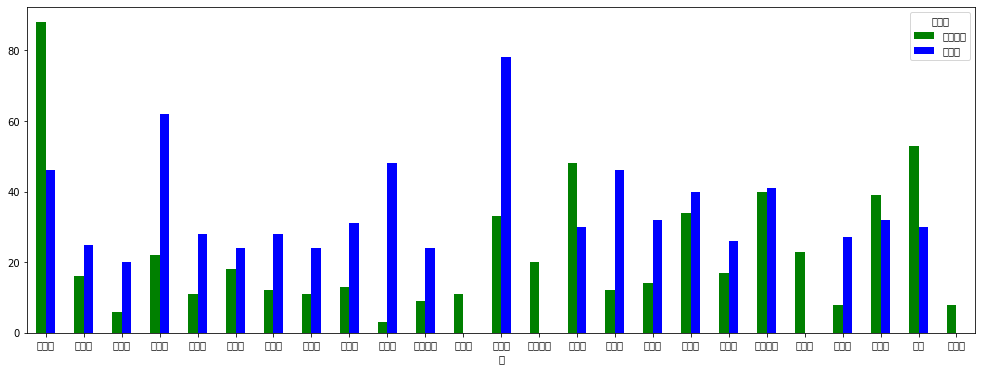

In [87]:
df_coffee_count.plot.bar(rot=0, figsize=(17,6), color=["green", "blue"])

In [88]:
df_coffee_count["위도"] = np.nan
df_coffee_count["경도"] = np.nan
for idx, rows in df_coffee_count.iterrows():
    temp = gmaps.geocode(idx, language="ko")
    if temp:
        lat = temp[0].get("geometry")["location"]["lat"]
        lng = temp[0].get("geometry")["location"]["lng"]
        df_coffee_count.loc[idx, "위도"] = lat
        df_coffee_count.loc[idx, "경도"] = lng
    else:
        print(idx, rows["주소"])

In [98]:
df_coffee_count

,스타벅스,이디야,위도,경도
구,,,,
강남구,88.0,46.0,37.517236,127.047325
강동구,16.0,25.0,37.530125,127.123762
강북구,6.0,20.0,37.639610,127.025657
강서구,22.0,62.0,37.550979,126.849538
관악구,11.0,28.0,37.478406,126.951613
광진구,18.0,24.0,37.538484,127.082294
구로구,12.0,28.0,37.495403,126.887369
금천구,11.0,24.0,37.451853,126.902036
노원구,13.0,31.0,37.654192,127.056793


In [99]:
df_coffee_count.columns = ["스타벅스", "이디야", "위도", "경도"]

In [101]:
seoul_center = [37.517692, 126.989912]
my_map = folium.Map(
    location=seoul_center,
    zoom_start=11.5,
    tiles="StamenToner"
)
for idx, rows in df_coffee_count.iterrows():
    folium.Circle(
        location=[rows["위도"], rows["경도"]],
        radius = rows["스타벅스"] * 50,
        fill = True,
        color = "green",
        fill_color = "green",
        popup = idx,
        tooltip = idx
    ).add_to(my_map)
    folium.Circle(
        location=[rows["위도"], rows["경도"]],
        radius = rows["이디야"] * 50,
        fill = True,
        color = "blue",
        fill_color = "blue",
        popup = idx,
        tooltip = idx
    ).add_to(my_map)
my_map